In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

DATA_PATH = "../data/processed/hvbp_2025_clean.parquet"
df = pd.read_parquet(DATA_PATH)


df.head()
df.describe()


,Facility ID,wt_clinical,wt_pce,wt_safety,wt_efficiency,tps
count,2489.000000,2445.000000,2485.000000,2081.000000,2489.000000,2489.000000
mean,257106.171555,4.340076,5.624346,9.977081,5.538369,23.758655
std,160442.715270,3.973351,4.802087,5.641767,7.617301,10.560229
min,10001.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100330.000000,1.250000,2.500000,5.833333,0.000000,16.166667
50%,250042.000000,3.500000,4.250000,9.166667,2.500000,22.000000
75%,390066.000000,6.500000,7.000000,13.333333,7.500000,30.000000
max,670309.000000,24.166667,33.333333,33.333333,33.333333,75.666667


## Checking the data distribution

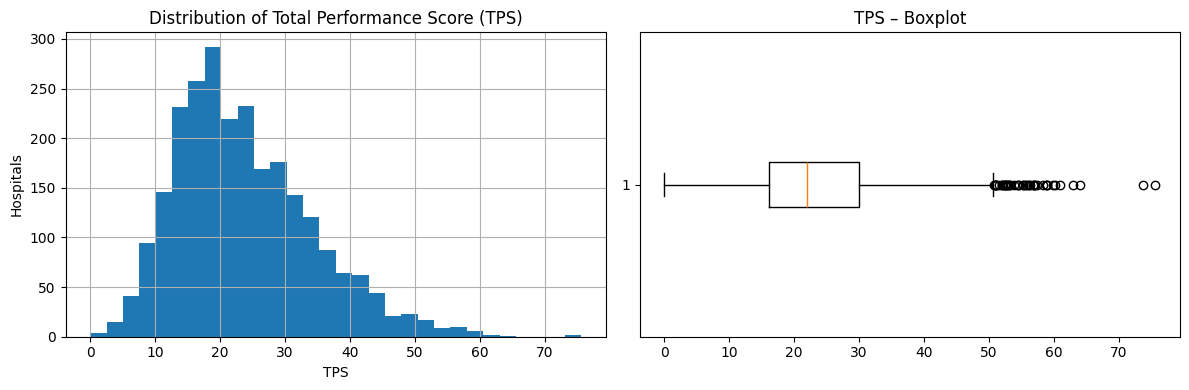

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df["tps"].hist(ax=ax[0], bins=30)
ax[0].set_title("Distribution of Total Performance Score (TPS)")
ax[0].set_xlabel("TPS"); ax[0].set_ylabel("Hospitals")

ax[1].boxplot(df["tps"], vert=False)
ax[1].set_title("TPS – Boxplot")
plt.tight_layout()
plt.savefig("../figures/tps_dist_box.png", dpi=150)


### Median ≈ 22; scores span 0 → 75.7

### Long right tail: a small group of hospitals strongly outperform.

## Plot each domain that reflects hospital quality

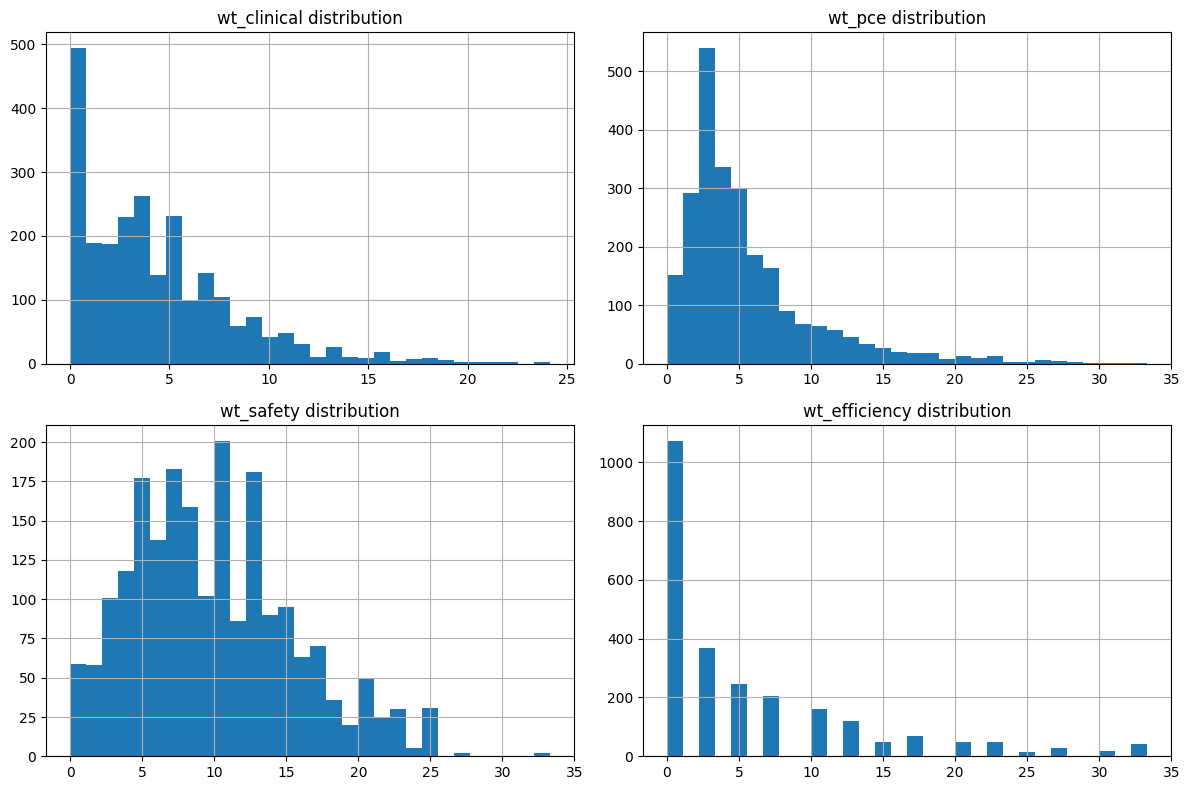

In [4]:
domain_cols = ["wt_clinical", "wt_pce", "wt_safety", "wt_efficiency"]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.ravel()
for i, col in enumerate(domain_cols):
    df[col].hist(ax=axs[i], bins=30)
    axs[i].set_title(f"{col} distribution")
plt.tight_layout()
plt.savefig("../figures/domain_hists.png", dpi=150)


## Checking for correlation between the domains and TPS

In [5]:
corr = df[domain_cols + ["tps"]].corr()
corr.style.background_gradient(cmap="coolwarm")


,wt_clinical,wt_pce,wt_safety,wt_efficiency,tps
wt_clinical,1.000000,-0.066542,-0.129221,-0.092762,0.280248
wt_pce,-0.066542,1.000000,0.062372,0.337995,0.493262
wt_safety,-0.129221,0.062372,1.000000,0.049416,0.584250
wt_efficiency,-0.092762,0.337995,0.049416,1.000000,0.697465
tps,0.280248,0.493262,0.584250,0.697465,1.000000


### Weighted Efficiency And Cost Reduction Domain Score has the strongest linear link in the table. Hospitals that spend less per Medicare episode (i.e., score well on the Efficiency & Cost-Reduction domain) almost always finish with high TPS. Followed by Weighted Safety Domain Score. Total Performance Score has the lowest correlation with weighted Normalized Clinical Outcomes Domain Score.

## Checking for percentage of hospitals without Safety domain Score

In [6]:
df["has_safety"] = df["wt_safety"].notna()
df["has_safety"].value_counts(normalize=True)


has_safety
True     0.836079
False    0.163921
Name: proportion, dtype: float64

### ≈ 16 % of hospitals are missing Safety data, so CMS re-weighted the other three domains for them.

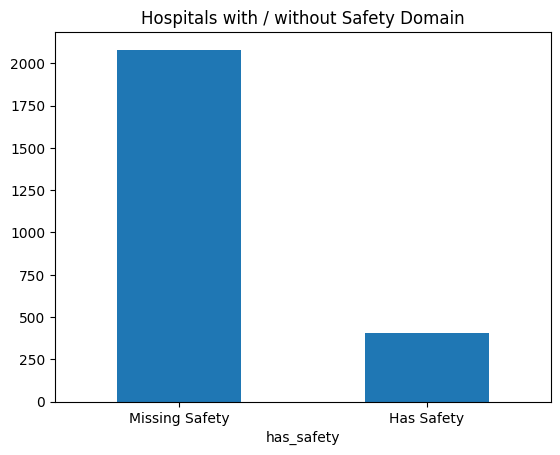

In [7]:
df["has_safety"].value_counts().plot(kind="bar")
plt.xticks([0,1], ["Missing Safety", "Has Safety"], rotation=0)
plt.title("Hospitals with / without Safety Domain")
plt.savefig("../figures/safety_missing_bar.png", dpi=150)


## Plotting State Map to show TPS performance by state and region

In [8]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [9]:
state_mean = (
    df.groupby("State", as_index=False)
      .agg(mean_tps=("tps", "mean"))
)

fig = px.choropleth(
    state_mean,
    locations="State",
    locationmode="USA-states",
    color="mean_tps",
    color_continuous_scale="Purples",
    scope="usa",
    title="Average TPS by State (FY 2025)"
)
fig.show()
fig.write_image("../figures/state_tps_map.png", scale=2)


## Pairplot

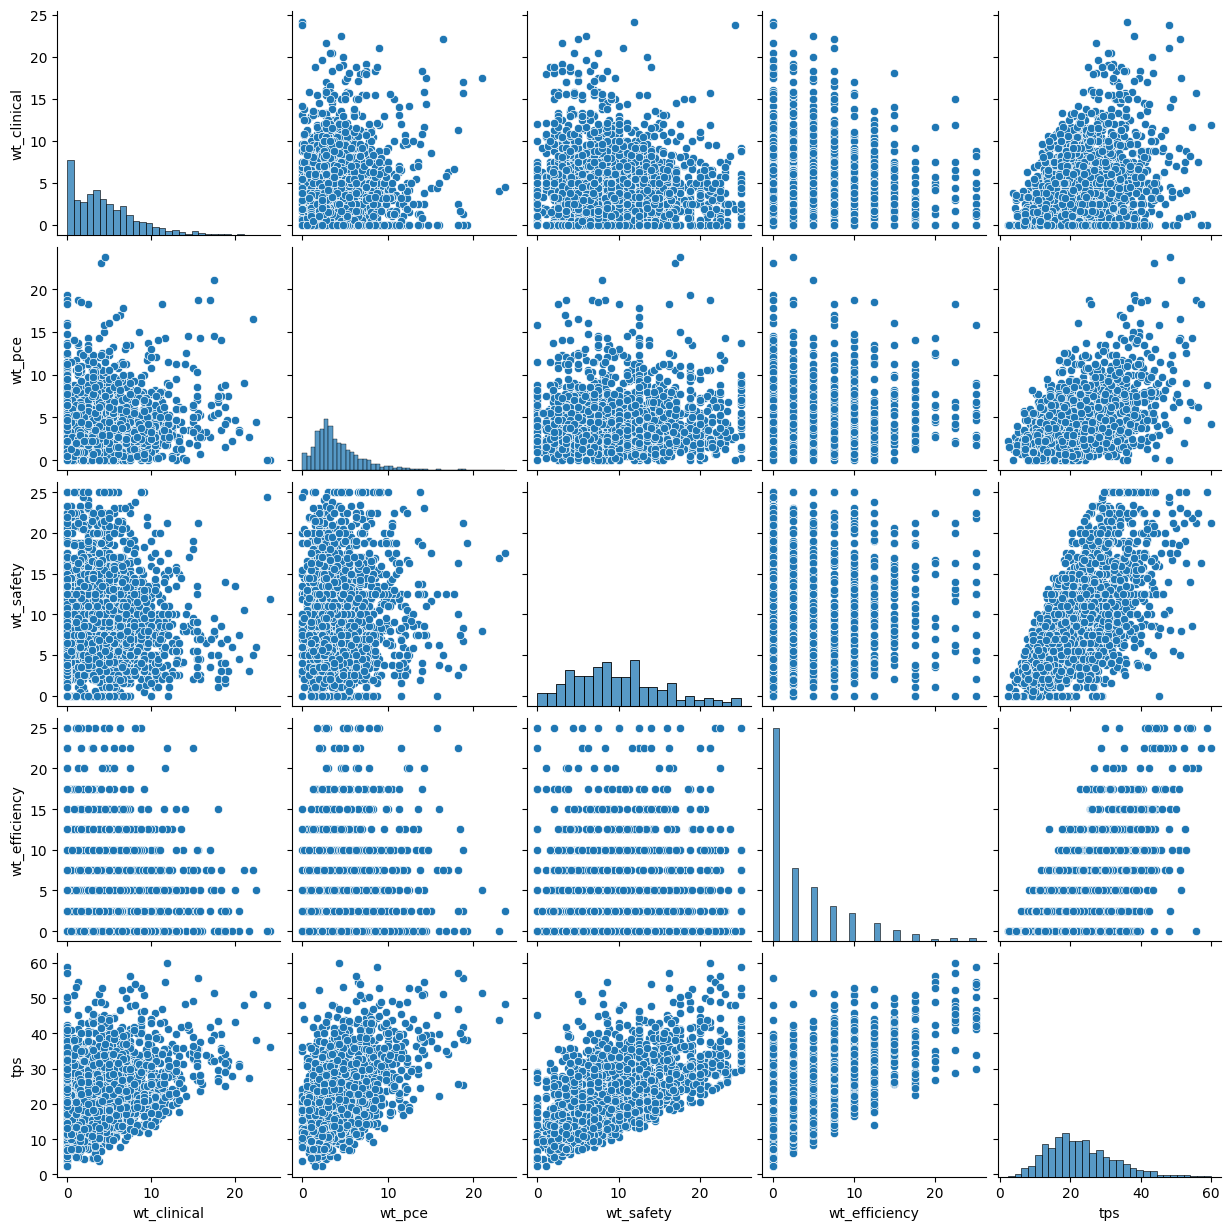

In [20]:
import seaborn as sns
sns.pairplot(df[domain_cols + ["tps"]].dropna())
plt.savefig("../figures/pairplot_domains_tps.png", dpi=150)


### There is a clear, positive slope between Efficiency and TPS; and Safety and TPS; much flatter for Clinical Outcomes. Cross-domain dots look evenly scattered.

In [21]:
q1, q3 = df["tps"].quantile([0.25, 0.75])
iqr = q3 - q1
upper_cut = q3 + 1.5 * iqr

outliers = df.loc[df["tps"] > upper_cut, 
                  ["Facility Name", "State", "tps"] + domain_cols]
outliers.head(10)


,Facility Name,State,tps,wt_clinical,wt_pce,wt_safety,wt_efficiency
19,KAISER FOUNDATION HOSPITAL - FREMONT,CA,52.000000,NaN,3.333333,15.333333,33.333333
141,BAPTIST NEIGHBORHOOD HOSPITAL THOUSAND OAKS,TX,51.000000,1.666667,16.000000,NaN,33.333333
276,ST LUKE'S HOSPITAL - CARBON CAMPUS,PA,51.125000,3.750000,14.250000,23.125000,10.000000
400,BAYLOR SCOTT & WHITE THE HEART HOSPITAL - PLANO,TX,55.625000,15.625000,18.750000,21.250000,0.000000
466,ESSENTIA HEALTH ST JOSEPH'S MEDICAL CENTER,MN,54.625000,1.250000,6.500000,21.875000,25.000000
555,METHODIST HEALTHCARE - OLIVE BRANCH HOSPITAL,MS,56.250000,7.500000,6.250000,22.500000,20.000000
712,ADIRONDACK MEDICAL CENTER - SARANAC LAKE,NY,53.000000,5.000000,24.666667,NaN,23.333333
731,MAYO CLINIC HEALTH SYSTEM - ALBERT LEA AND AUSTIN,MN,59.875000,11.875000,4.250000,21.250000,22.500000
934,UP HEALTH SYSTEM PORTAGE,MI,58.333333,1.666667,26.666667,NaN,30.000000
970,GRAND ITASCA CLINIC AND HOSPITAL,MN,56.333333,6.666667,16.333333,NaN,33.333333


### 46 hospitals ( ≈ 1.9 % of the 2 489-hospital universe)
### 10 states contribute > 70 % of all outliers. 

### The top five are:
• MI (8) 

• MN (6) 

• WI (6) 

• CA (5) 

• NC (3)

Exactly half (23) lack a Safety score. Those hospitals compensate with bigger gains in the other three domains (mostly Efficiency & Person And Community Engagement)


### With Safety data (n = 23)
(mean values)
• TPS = 54.1

• Efficiency ≈ 19.6 

• Safety ≈ 17.8 

• PCE ≈ 10.8 
• Clinical ≈ 7.6

### Without Safety (n = 23)
(mean values)
• TPS = 57.8 (Total Performance Score is higher)

• Efficiency ≈ 30.4 

• PCE ≈ 20.5 

• Clinical ≈ 6.9



In [22]:
outliers.to_csv("../figures/top_tps_outliers.csv", index=False)
